In [21]:
import pandas as pd
import numpy as np
import json
import os
from collections import defaultdict
from fuzzywuzzy import fuzz

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import pearsonr


### Generate Alignment Table

In [22]:
baselines = ["vanilla", "cot", "socratic", "subq"]
datasets = ["massmaps", "supernova", "politeness", "emotion", "cholec", "cardiac", "sepsis"]
models = ["gpt-4o"]

# Map for pretty LaTeX-style formatting of baselines
baseline_names = {
    "vanilla": "\\textbf{Vanilla}",
    "cot": "\\textbf{Chain-of-Thought}",
    "socratic": "\\textbf{Socratic Prompting}",
    "subq": "\\textbf{SubQ Decomposition}"
}

# Collect scores
alignment_dict = defaultdict(list)
alignment_avgs = defaultdict(list)

for model in models:
    for baseline in baselines:
        for dataset in datasets:
            path = os.path.join(baseline, f"{dataset}_{model}.json")
            path = os.path.join("../results", path)
            if not os.path.exists(path):
                print(f"File not found: {path}")
                continue
            with open(path, 'r') as f:
                try:
                    data = json.load(f)
                    scores = [entry["final_alignment_score"] for entry in data if "final_alignment_score" in entry and entry["final_alignment_score"] is not None]
                    if scores:
                        alignment_dict[(baseline, dataset, model)] = scores
                        avg = sum(scores) / len(scores)
                        alignment_avgs[(baseline, dataset, model)] = avg
                    #print length of scores
                    if(len(scores) < 100):
                        print(f"Warning: Less than 100 scores for {baseline} on {dataset}: {len(scores)}")
                except Exception as e:
                    print(scores)
                    print(f"Error processing {path}: {e}")

    # Generate LaTeX rows
    print("-----------{}------------".format(model))
    for baseline in baselines:
        row = [baseline_names[baseline]]
        for dataset in datasets:
            avg_score = alignment_avgs.get((baseline, dataset, model), "")
            if isinstance(avg_score, float):
                row.append(f"{avg_score:.2f}")
            else:
                row.append("")  # Leave blank if not available
                print(f"Warning: No score found for {baseline} on {dataset}")
        print(" & ".join(row) + " \\\\")

-----------gpt-4o------------
\textbf{Vanilla} & 0.42 & 0.88 & 0.63 & 0.64 & 0.30 & 0.53 & 0.54 \\
\textbf{Chain-of-Thought} & 0.39 & 0.86 & 0.62 & 0.61 & 0.34 & 0.56 & 0.53 \\
\textbf{Socratic Prompting} & 0.41 & 0.86 & 0.60 & 0.62 & 0.37 & 0.57 & 0.54 \\
\textbf{SubQ Decomposition} & 0.35 & 0.88 & 0.60 & 0.58 & 0.36 & 0.52 & 0.56 \\


### Generate Accuracy Table

In [23]:
baselines = ["vanilla", "cot", "socratic", "subq"]
datasets = ["massmaps", "supernova", "politeness", "emotion", "cholec", "cardiac", "sepsis"]
models = ["gpt-4o"]

# Map for pretty LaTeX-style formatting of baselines
baseline_names = {
    "vanilla": "\\textbf{Vanilla}",
    "cot": "\\textbf{Chain-of-Thought}",
    "socratic": "\\textbf{Socratic Prompting}",
    "subq": "\\textbf{SubQ Decomposition}"
}


# Collect scores
accuracy_dict = defaultdict(list)
accuracy_avgs = defaultdict(list)

for model in models:
    for baseline in baselines:
        for dataset in datasets:
            path = os.path.join(baseline, f"{dataset}_{model}.json")
            path = os.path.join("../results", path)
            if not os.path.exists(path):
                print(f"File not found: {path}")
                continue
            with open(path, 'r') as f:
                try:
                    accuracy = []
                    data = json.load(f)
                    if "accuracy" in data[0]:
                        accuracy = [entry["accuracy"] for entry in data if entry["accuracy"] is not None and entry["final_alignment_score"] is not None]   
                    elif "mse" in data[0]:
                        accuracy = [entry["mse"] for entry in data if entry["mse"] is not None and entry["final_alignment_score"] is not None]   
                    elif "mse_loss" in data[0]:
                        accuracy = [(entry["mse_loss"]["Omega_m"] + entry["mse_loss"]["sigma_8"])/2 for entry in data if entry["mse_loss"] is not None and entry["final_alignment_score"] is not None]
                    elif "safe_iou" in data[0]:
                        accuracy = [(entry["safe_iou"] + entry["unsafe_iou"])/2 for entry in data if entry["safe_iou"] is not None and entry["final_alignment_score"] is not None]
                    else:
                        print(f"Neither accuracy nor mse found in {path}")           
                    if accuracy:
                        accuracy_dict[(baseline, dataset, model)] = accuracy
                        avg = sum(accuracy) / len(accuracy)
                        accuracy_avgs[(baseline, dataset, model)] = avg
                        
                    if(len(accuracy) < 100):
                        print(f"Warning: Less than 100 scores for {baseline} on {dataset}: {len(accuracy)}")
                except Exception as e:
                    print(f"Error processing {path}: {e}")

    print("-----------{}------------".format(model))
    for baseline in baselines:
        row = [baseline_names[baseline]]
        for dataset in datasets:
            avg_score = accuracy_avgs.get((baseline, dataset, model), "")
            if isinstance(avg_score, float):
                row.append(f"{avg_score:.2f}")
            else:
                row.append("")  # Leave blank if not available
                print(f"Warning: No score found for {baseline} on {dataset}")
        print(" & ".join(row) + " \\\\")


-----------gpt-4o------------
\textbf{Vanilla} & 0.04 & 0.10 & 0.92 & 0.26 & 0.07 & 0.57 & 0.66 \\
\textbf{Chain-of-Thought} & 0.04 & 0.09 & 0.82 & 0.27 & 0.10 & 0.46 & 0.71 \\
\textbf{Socratic Prompting} & 0.04 & 0.13 & 0.83 & 0.29 & 0.11 & 0.46 & 0.66 \\
\textbf{SubQ Decomposition} & 0.05 & 0.12 & 0.84 & 0.29 & 0.12 & 0.48 & 0.66 \\


### Criteria Coverage Analysis

/tmp/ipykernel_3117157/534804577.py:100: UserWarning: The palette list has more values (10) than needed (4), which may not be intended.
  sns.barplot(


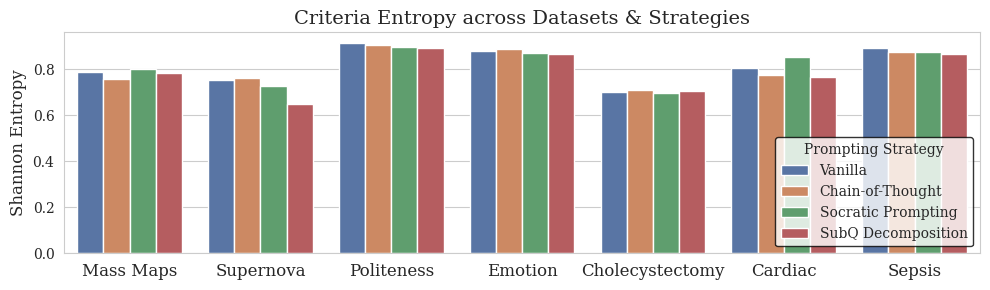

In [24]:
from collections import Counter
from math import log2

def shannon_entropy(data):
    total = len(data)
    counts = Counter(data)
    k = len(counts)  # number of unique elements
    if k <= 1:
        return 0.0  # No uncertainty if only one unique value

    entropy = -sum((freq / total) * log2(freq / total) for freq in counts.values())
    max_entropy = log2(k)
    return entropy / max_entropy

baselines = ["vanilla", "cot", "socratic", "subq"]
datasets = ["massmaps", "supernova", "politeness", "emotion", "cholec", "cardiac", "sepsis"]
models = ["gpt-4o"]

dataset_names = {
    "massmaps": "Mass Maps",
    "supernova": "Supernova",
    "politeness": "Politeness",
    "emotion": "Emotion",
    "cholec": "Cholecystectomy",
    "cardiac": "Cardiac",
    "sepsis": "Sepsis"
}

baseline_names = {
    "vanilla": "Vanilla",
    "cot": "Chain-of-Thought",
    "socratic": "Socratic Prompting",
    "subq": "SubQ Decomposition"
}

entropies = defaultdict(list)

for baseline in baselines:
    for model in models: 
        for dataset in datasets:
            categories_all = []
            path = os.path.join(baseline, f"{dataset}_{model}.json")
            path = os.path.join("../results", path)
            if not os.path.exists(path):
                print(f"File not found: {path}")
                continue
            with open(path, 'r') as f:
                try:
                    categories = []
                    data = json.load(f)
                    if "alignment_categories" in data[0]:
                        categories = [entry["alignment_categories"] for entry in data if entry["alignment_categories"] is not None] 
                    elif "alignment_category" in data[0]:
                        categories = [entry["alignment_category"] for entry in data if entry["alignment_category"] is not None]
                    elif "aligned_category_ids" in data[0]:
                        categories = [entry["aligned_category_ids"] for entry in data if entry["aligned_category_ids"] is not None]
                    elif "alignment_category_ids" in data[0]:
                        categories = [entry["alignment_category_ids"] for entry in data if entry["alignment_category_ids"] is not None]
                    else:
                        raise ValueError(f"alignment_categories not found in {path}") 
                    for category_list in categories:
                        for category_item in category_list:
                            if category_item is not None:
                                categories_all.append(category_item)
                except Exception as e:
                    print(f"Error processing {path}: {e}")           

            names, counts = np.unique(categories_all, return_counts=True)
            ent = shannon_entropy(categories_all)
            entropies[(baseline, dataset)] = ent

entropy_data = entropies
# Convert to DataFrame
rows = [(baseline_names[baseline], dataset_names[dataset], value) for (baseline, dataset), value in entropy_data.items()]
df = pd.DataFrame(rows, columns=["Baseline", "Dataset", "Entropy"])

mpl.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'Times', 'DejaVu Serif'],
    'axes.labelweight': 'normal',
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 10,
    'legend.fontsize': 10
})

# Avoid Seaborn overriding the font
sns.set_style("whitegrid", rc={
    'font.family': 'serif',
    'axes.labelweight': 'normal',
    'axes.edgecolor': '0.8'
})

# Plot setup
plt.figure(figsize=(10, 3))  # Adjust size to fit Overleaf width
palette = sns.color_palette("deep")

# Create horizontal barplot
sns.barplot(
    data=df,
    y="Entropy", x="Dataset", hue="Baseline",
    dodge=True,
    palette=palette
)

# Formatting
plt.title("Criteria Entropy across Datasets & Strategies", fontsize=14)
plt.xlabel("", labelpad=0)
plt.ylabel("Shannon Entropy")
plt.legend(
    title="Prompting Strategy",
    loc="lower right",
    bbox_to_anchor=(1, 0),
    frameon=True,
    facecolor='white',
    edgecolor='black'
)
plt.tight_layout()

# Save to file
plt.savefig("entropy_histogram.pdf")  # Or .png if you prefer
plt.show()

### Correlation Heatmap

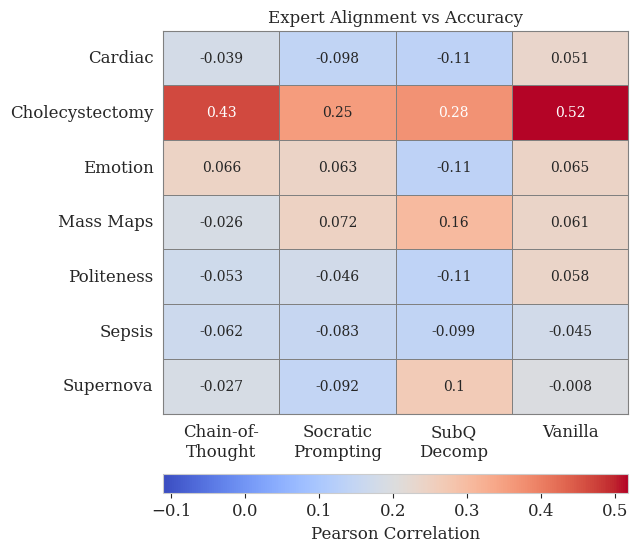

In [27]:
dataset_names = {
    "massmaps": "Mass Maps",
    "supernova": "Supernova",
    "politeness": "Politeness",
    "emotion": "Emotion",
    "cholec": "Cholecystectomy",
    "cardiac": "Cardiac",
    "sepsis": "Sepsis"
}
baseline_names = {
    "vanilla": "Vanilla",
    "cot": "Chain-of-\nThought",
    "socratic": "Socratic\nPrompting",
    "subq": "SubQ\nDecomp"
}

data = []
for key in alignment_dict:
    align = alignment_dict.get(key)
    acc = accuracy_dict.get(key)
    if align and acc and len(align) == len(acc):
        corr, _ = pearsonr(align, acc)
    else:
        print(f"Warning: Mismatched lengths for {key}: {len(align)} vs {len(acc)}")
    baseline, dataset, model = key
    data.append((baseline_names[baseline], dataset_names[dataset], corr))

# Step 2: Convert to DataFrame
df_corr = pd.DataFrame(data, columns=['Baseline', 'Dataset', 'Correlation'])

# Step 3: Pivot for heatmap
heatmap_data = df_corr.pivot(index='Dataset', columns='Baseline', values='Correlation')

# Step 4: Plot heatmap
fig, ax = plt.subplots(figsize=(6, 6))

# Draw the heatmap without the default colorbar
sns_heatmap = sns.heatmap(
    heatmap_data,
    annot=True,
    center=0,
    linewidths=0.5,
    linecolor='gray',
    cmap="coolwarm",
    cbar=False,
    ax=ax
)

# Create a new horizontal colorbar below the heatmap
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.6)

# Now draw the colorbar manually
norm = plt.Normalize(vmin=heatmap_data.min().min(), vmax=heatmap_data.max().max())
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cax, orientation='horizontal')
cbar.set_label("Pearson Correlation")

# Label formatting
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')
#font size
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title("Expert Alignment vs Accuracy")
ax.set_xlabel("")
ax.set_ylabel("")

# plt.tight_layout()
for spine in ax.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('gray')
    
plt.savefig("correlation_heatmap.pdf")
plt.show()

In [ ]:
accuracy_dict.keys()

dict_keys([('vanilla', 'massmaps'), ('vanilla', 'supernova'), ('vanilla', 'politeness'), ('vanilla', 'emotion'), ('vanilla', 'cholec'), ('vanilla', 'cardiac'), ('vanilla', 'sepsis'), ('cot', 'massmaps'), ('cot', 'supernova'), ('cot', 'politeness'), ('cot', 'emotion'), ('cot', 'cholec'), ('cot', 'cardiac'), ('cot', 'sepsis'), ('socratic', 'massmaps'), ('socratic', 'supernova'), ('socratic', 'politeness'), ('socratic', 'emotion'), ('socratic', 'cholec'), ('socratic', 'cardiac'), ('socratic', 'sepsis'), ('subq', 'massmaps'), ('subq', 'supernova'), ('subq', 'politeness'), ('subq', 'emotion'), ('subq', 'cholec'), ('subq', 'cardiac'), ('subq', 'sepsis')])